## 1 SIFT 
### 1.1 Prétraitement des données 

    - Changement de taille des images 
    - Filtre de l'image en gris
    - Extraction des descriptors 
    - Création des bag of images 
    
### 1.2 Classification supervisée des bag of images 
    - test avec de plusieurs modèles avec grid search cv
    - matrice de confusion sur les prédictions du modèle de régression logistique
 
## 2 Model pré-entrainé VGG16
### 2.1 Prétraitement des données     
    - Extraction des features 
    - PCA
    - T-SNE
    - Matrice de confusion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

import time
import datetime

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
df = pd.read_csv('Source/flipkart_com-ecommerce_sample_1050.csv',sep=',')

In [4]:
path_img = 'Source/Images'

In [5]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [6]:
# lire des caractère sur une image
import nltk
nltk.download('punkt')
tokenizer = nltk.RegexpTokenizer(r'\w+')
token = np.array(df.product_category_tree)

token = [tokenizer.tokenize(i.lower()) for i in token]

bigram = [list(nltk.bigrams(bigram)) for bigram in token]

token_bigram = pd.Series(bigram)

cat_name = np.array([token_bigram[i][0] for i in range(len(token_bigram))])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dragomir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
df_token = pd.DataFrame(cat_name, columns=['cat1','cat2'])
df_token = df_token.cat1 

In [8]:
df['category_name'] = df_token

In [9]:
from sklearn import preprocessing


# preprocessing encodage des données
encodage = preprocessing.LabelEncoder()
encodage.fit(df.category_name)
df["label"] = encodage.transform(df.category_name)
# data.head(5)
df.category_name.value_counts()

home         300
baby         150
watches      150
kitchen      150
beauty       150
computers    150
Name: category_name, dtype: int64

In [10]:
img = [img for img in df.image]
img_path = []

for i in range(len(img)):
    img_path.append(path_img+"/"+img[i])
    df['path_img'] = path_img+"/"+img[i]

In [11]:
img_path[1]

'Source/Images/7b72c92c2f6c40268628ec5f14c6d590.jpg'

### 1 SIFT 
### 1.1Prétraitement des données

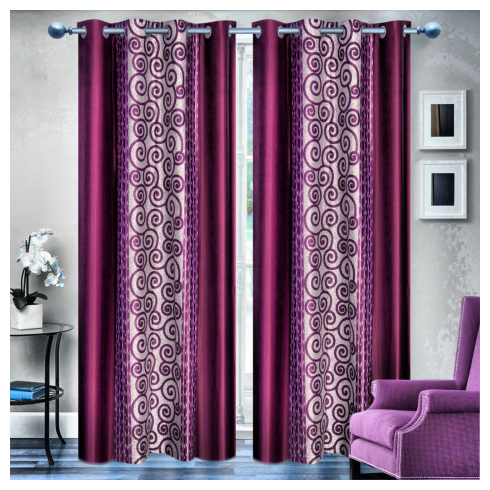

Text(0.5, 1.0, 'Adaptive equalization')

In [12]:
# egalizateur de contraste

from skimage import data, img_as_float
from skimage import exposure
def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img = axes
    #ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()
    
    # prevent overlap of y-axis labels
    fig.tight_layout()
    plt.show()
img = cv2.imread(img_path[0])
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    
# Display results
fig = plt.figure(figsize=(8, 5))
axes = plt.subplot()
plot_img_and_hist(img_adapteq, axes)
axes.set_title('Adaptive equalization')

temps :             0.77 secondes


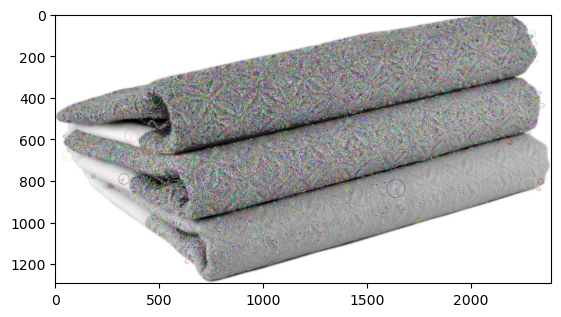

In [13]:
# Important NOTE: Use opencv <= 3.4.2.16 as
# SIFT is no longer available in
# opencv > 3.4.2.16


time1 = time.time()

# Loading the image
img_ = cv2.imread(img_path[1],cv2.IMREAD_GRAYSCALE)


# Converting image to grayscale
gray= cv2.cvtColor(img_,cv2.COLOR_GRAY2BGR)


# Applying SIFT detector
sift = cv2.xfeatures2d.SIFT_create()
keyp , descript = sift.detectAndCompute(gray,None)


# Marking the keypoint on the image using circles
img=cv2.drawKeypoints(gray ,
                      keyp ,
                      0,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

duration1=time.time()-time1
print("temps : ", "%15.2f" % duration1, "secondes")

plt.imshow(img)

### Extraction des descriptors 

In [14]:
time1 = time.time()

image_descripteur = []
image_descripteur_org = []
image_features = []
for idx,image_file in enumerate(img_path) :
    if idx%100 == 0: print('cpt = ',idx)
    # Loading the image
    img = cv2.imread(image_file,cv2.IMREAD_GRAYSCALE)
    
    img = cv2.resize(img, (500, 500))
    # egaliseur de couleur

    # Converting image to grayscale
    gray= cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Utilisez img au lieu de img_

    # Applying SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    #img_adapteq = exposure.equalize_adapthist(img_, clip_limit=0.03)

    # Convertir l'image en uint8 (CV_8U)
    #img_adapteq_uint8 = (img_adapteq).astype('uint8')
    kp , descripteurs = sift.detectAndCompute(gray,None)

    # Marking the keypoint on the image using circles
    img_ =cv2.drawKeypoints(gray  ,
                          kp ,
                          0,
                          flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    try : 
        
        descripteurs_norm = np.linalg.norm(descripteurs, axis=1, keepdims=True)
        descripteurs_normalises = descripteurs / descripteurs_norm
    except : 
        descripteurs_normalises = 0
    
    # Seuillage des valeurs des vecteurs de descripteurs
    seuil = 0.2
    descripteurs_seuilles = np.minimum(descripteurs_normalises, seuil)
    image_descripteur_org.append(descripteurs)
    image_descripteur.append(descripteurs_seuilles)
    image_features.append(img_) 
    #image_kp.append([key.pt for key in key_points])

duration1=time.time()-time1
print("temps : ", "%15.2f" % duration1, "secondes")

cpt =  0
cpt =  100
cpt =  200
cpt =  300
cpt =  400
cpt =  500
cpt =  600
cpt =  700
cpt =  800
cpt =  900
cpt =  1000
temps :            77.63 secondes


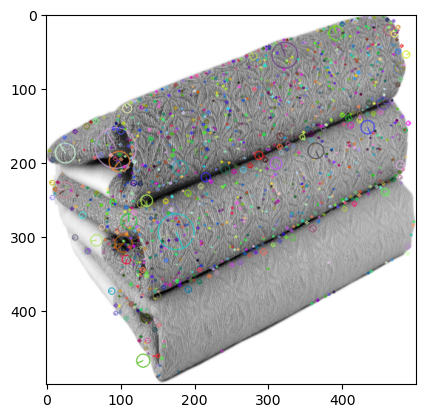

In [15]:
plt.imshow(image_features[1])

In [16]:
# check que les lignes ne sont pas vide avant de concaténer 
for i,des in enumerate(image_descripteur_org):
    try:
        #print('i:',i,'___',des.shape[0])
        if len(des) != 0:
            continue
    except:
        print('error ligne :',i)
        image_descripteur_org[i] = np.zeros((1,128))
        

error ligne : 343


In [17]:
len(image_descripteur)

1050

In [18]:
descripteurs = np.concatenate(image_descripteur_org,axis=0)

descripteurs.shape


(964010, 128)

In [19]:
#image_descripteur_org = np.concatenate(image_descripteur_org,axis=0)
#image_descripteur_org.shape

In [20]:
descripteurs[11100]

array([ 28.,   1.,   0.,   0.,   0.,   0.,   0.,   2., 151.,   4.,   1.,
         3.,   1.,   0.,   0.,  21., 100.,   8.,   4., 140., 143.,   0.,
         0.,   3.,   0.,   0.,   0.,  97., 112.,   0.,   0.,   0.,  41.,
         1.,   0.,   0.,   0.,   2.,   4.,  12., 151.,  11.,   2.,  20.,
        13.,   0.,   0.,  33.,  71.,   8.,   3., 151., 151.,   0.,   0.,
         2.,   0.,   0.,   1.,  56.,  65.,   0.,   0.,   0.,  19.,   2.,
         2.,   0.,   0.,  11.,  33.,  36., 151.,  84.,  15.,  24.,  19.,
         0.,   1.,  31.,  16.,  26.,  15., 103., 151.,  21.,   0.,   0.,
         0.,   0.,   0.,  10.,  28.,  13.,   5.,   0.,  20.,  19.,  16.,
         0.,   1.,   3.,   7.,   8.,  10.,  49.,  17.,   6.,   5.,   2.,
         2.,   4.,   1.,  22.,  27.,  22.,  53.,  22.,   1.,   1.,   0.,
         1.,   7.,   7.,  13.,  26.,  15.,   0.])

### Création des bag of images 

In [21]:
from sklearn import cluster, metrics
import math
import time
time1 = time.time()

#k = int(round(math.sqrt(len(descripteurs)),0))
k = 80
print('nombre de clusters : ',k)
cls = cluster.MiniBatchKMeans(n_clusters=k,random_state=0, init_size=3*k)
cls.fit(descripteurs)


duration1=time.time()-time1
print("temps du Kmeans : ", "%15.2f" % duration1, "secondes")

nombre de clusters :  80


C:\Users\Dragomir\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
C:\Users\Dragomir\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1962: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


temps du Kmeans :             8.08 secondes


In [22]:
cls.cluster_centers_.shape

(80, 128)

In [23]:
cls.labels_.min(),cls.labels_.max()

(0, 79)

In [24]:
cls.n_clusters

80

In [25]:
def buil_histogram(kmeans,descripteur):
    try:
        des_pred = kmeans.predict(descripteur)
        nb_des = len(descripteur)

        val, _ = np.histogram(des_pred,bins = np.arange(cls.n_clusters+1))
        # normalise les bags of features
        return val/nb_des

    except:
        print('erreur histogramme')
        return np.zeros(len(kmeans.cluster_centers_))

histogram_descripteurs = []

In [26]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category_name,label,path_img
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home,3,Source/Images/f2f027ad6a6df617c9f125173da71e44...
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",baby,0,Source/Images/f2f027ad6a6df617c9f125173da71e44...
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",baby,0,Source/Images/f2f027ad6a6df617c9f125173da71e44...
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home,3,Source/Images/f2f027ad6a6df617c9f125173da71e44...
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",home,3,Source/Images/f2f027ad6a6df617c9f125173da71e44...


Text(0.5, 1.0, 'Image 3')

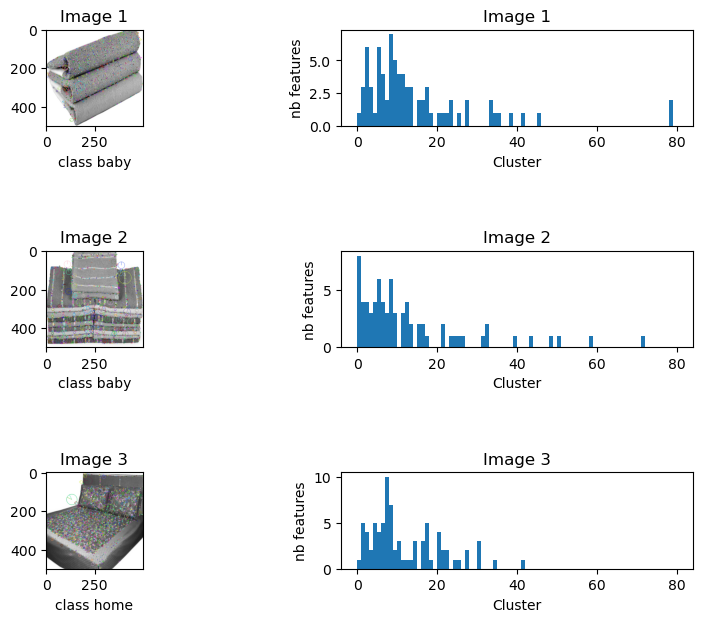

In [27]:
des = np.array(image_descripteur_org[1],dtype = np.float64)
des_pred = cls.predict(des)
val, _ = np.histogram(des_pred,bins = np.arange(cls.n_clusters+1))
des2 = np.array(image_descripteur_org[2],dtype = np.float64)
des_pred2 = cls.predict(des2)
val2, _ = np.histogram(des_pred2,bins = np.arange(cls.n_clusters+1))
des3 = np.array(image_descripteur_org[23],dtype = np.float64)
des_pred3 = cls.predict(des3)
val3, _ = np.histogram(des_pred3,bins = np.arange(cls.n_clusters+1)
                      )
fig, ax = plt.subplots(3,2,figsize= (10,7))
fig.subplots_adjust(hspace=1.3)

ax[0][0].imshow(image_features[1])
ax[0][0].set_xlabel('class baby')
ax[0][0].set_title('Image 1')
ax[0][1].hist(val,bins = np.arange(cls.n_clusters+1))
ax[0][1].set_xlabel('Cluster')
ax[0][1].set_ylabel('nb features')
ax[0][1].set_title('Image 1')
ax[1][0].imshow(image_features[2])
ax[1][0].set_xlabel('class baby')
ax[1][0].set_title('Image 2')
ax[1][1].hist(val2,bins = np.arange(cls.n_clusters+1))
ax[1][1].set_xlabel('Cluster')
ax[1][1].set_ylabel('nb features')
ax[1][1].set_title('Image 2')
ax[2][0].imshow(image_features[3])
ax[2][0].set_xlabel('class home')
ax[2][0].set_title('Image 3')
ax[2][1].hist(val3,bins = np.arange(cls.n_clusters+1))
ax[2][1].set_xlabel('Cluster')
ax[2][1].set_ylabel('nb features')
ax[2][1].set_title('Image 3')


In [28]:
len(descripteurs),cls.n_clusters,len(cls.cluster_centers_)

(964010, 80, 80)

In [29]:
import time

t0 = time.time()

for i in range(len(image_descripteur_org)):
    des = np.array(image_descripteur_org[i],dtype = np.float64)
    histogram_descripteurs.append(buil_histogram(cls,des))
    if i%200 ==0:print(i)
    
time = time.time() - t0

print(f'temps d execution : {time}')

0
200
400
600
800
1000
temps d execution : 2.4809958934783936


In [30]:
histogram_descripteurs[0]

array([0.00329707, 0.00758325, 0.01450709, 0.01615562, 0.01846357,
       0.03198154, 0.02736564, 0.00857237, 0.00263765, 0.01088032,
       0.0151665 , 0.06000659, 0.00560501, 0.00725354, 0.00725354,
       0.00857237, 0.02110122, 0.01088032, 0.00560501, 0.00461589,
       0.0148368 , 0.00065941, 0.0049456 , 0.00659413, 0.00395648,
       0.01121002, 0.01121002, 0.00395648, 0.00329707, 0.00296736,
       0.00593472, 0.00560501, 0.01780415, 0.02274975, 0.02143093,
       0.03956479, 0.00593472, 0.04220244, 0.01153973, 0.00659413,
       0.00329707, 0.0049456 , 0.00098912, 0.00824266, 0.01252885,
       0.00692384, 0.00395648, 0.00791296, 0.05802835, 0.02077151,
       0.03099242, 0.02044181, 0.0049456 , 0.00560501, 0.01615562,
       0.01549621, 0.00296736, 0.01055061, 0.00659413, 0.00329707,
       0.02143093, 0.01186944, 0.00956149, 0.00230795, 0.00263765,
       0.02901418, 0.01681503, 0.00890208, 0.0052753 , 0.01318826,
       0.00428619, 0.00791296, 0.00923178, 0.01186944, 0.02110

In [31]:
#df_feat = pd.DataFrame(histogram_descripteurs).fillna(0)

In [32]:
from sklearn import manifold, decomposition

print(histogram_descripteurs[0].shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(histogram_descripteurs)
print(feat_pca.shape)

(80,)
(1050, 64)


In [38]:
histogram_descripteurs = np.array(histogram_descripteurs)
histogram_descripteurs.shape

(1050, 80)

In [40]:
import time
temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(histogram_descripteurs)

df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["cluster"] = df["label"]
df_tsne['cluster'].unique()

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")



temps de T-SNE :             8.24 secondes


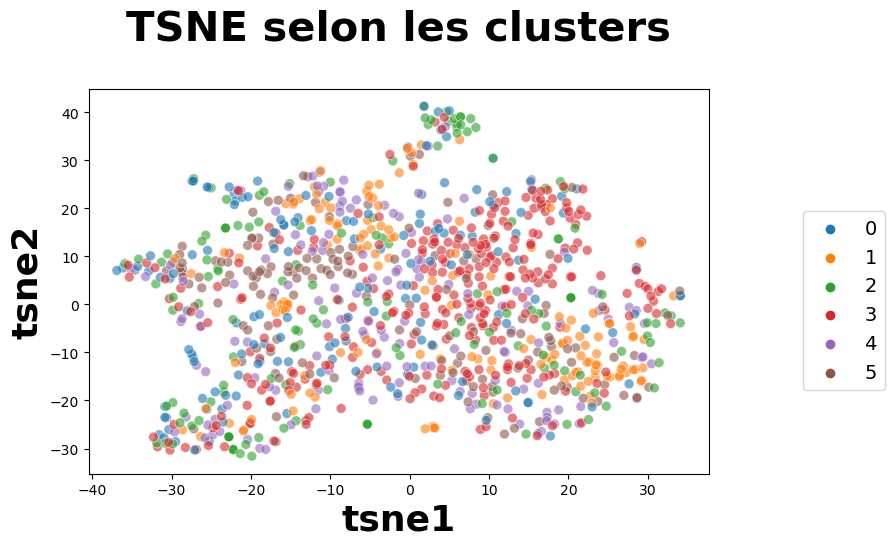

In [41]:

plt.figure(figsize=(8,5))
sns.scatterplot(
                x="tsne1",
                y="tsne2",
                hue="cluster",
                palette=sns.color_palette('tab10', n_colors=6), s=50, alpha=0.6,
                data=df_tsne,
                legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14},loc = 'right',bbox_to_anchor=(0.8, 0.2, 0.5, 0.5)) 

plt.show()

## 1.2 Classification supervisée des bag of images 

In [42]:
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [43]:
model = SVC()

Scaller = StandardScaler()

X = histogram_descripteurs
y = df.label

X = Scaller.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.array([list(x) for x in X_train])


model.fit(X_train,y_train)
y_pred = model.predict(X_test)

score = model.score(X_test,y_test)     
print(f" score = {round(score,2)} ")



 score = 0.54 


In [44]:
len(image_descripteur_org[0])

3033

In [45]:
# test de prédiction 
test = np.array(image_descripteur_org[10],dtype = np.float64)
predictions = cls.predict(test)
pred,_ = np.histogram(predictions, bins=np.arange(cls.n_clusters +1)/len(image_descripteur_org[1030]))

result = model.predict(pred.reshape(1,-1))
print(f'categorie de image : {df.label[104]}, resultat prediction : {result}')

categorie de image : 3, resultat prediction : [3]


In [46]:
t0 = time.time()

pipe = Pipeline([
                ("estimator",LogisticRegression())
                ])
pipe


X = histogram_descripteurs
y = df.label


param_grid = {
              'estimator':[RandomForestClassifier(),
                           AdaBoostClassifier(),
                           GradientBoostingClassifier(),
                           ExtraTreesClassifier(),
                           DecisionTreeClassifier(),
                           SVC(),
                           BaggingClassifier(),
                           KNeighborsClassifier(13),
                           LogisticRegression()
                          ]}


grid = GridSearchCV(pipe,param_grid=param_grid, cv=5,return_train_score=True ,n_jobs=-1, verbose=1)

grid.fit(X,y)

grid_cv = pd.DataFrame(grid.cv_results_)

new_cols = [i for i in grid_cv.columns if 'split' not in i.lower()]

duration1=time.time() - t0
print("temps : ", "%15.2f" % duration1, "secondes")

grid_cv.loc[:,new_cols].sort_values('mean_test_score', ascending=False)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
temps :            53.81 secondes


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
0,2.693914,0.041497,0.020399,0.000489,RandomForestClassifier(),{'estimator': RandomForestClassifier()},0.518095,0.051675,1,1.000000,0.000000
5,0.148398,0.033682,0.227601,0.283945,SVC(),{'estimator': SVC()},0.496190,0.036316,2,0.727143,0.006624
3,0.924997,0.075301,0.024401,0.002576,ExtraTreesClassifier(),{'estimator': ExtraTreesClassifier()},0.495238,0.043540,3,1.000000,0.000000
2,46.867414,0.317585,0.003798,0.000400,GradientBoostingClassifier(),{'estimator': GradientBoostingClassifier()},0.481905,0.042847,4,0.999762,0.000476
6,2.302722,0.138583,0.006194,0.000755,BaggingClassifier(),{'estimator': BaggingClassifier()},0.467619,0.029723,5,0.988571,0.002777
7,0.006199,0.005564,0.046602,0.068050,KNeighborsClassifier(n_neighbors=13),{'estimator': KNeighborsClassifier(n_neighbors...,0.444762,0.019657,6,0.534524,0.013657
1,2.115920,0.036609,0.026398,0.004317,AdaBoostClassifier(),{'estimator': AdaBoostClassifier()},0.424762,0.034127,7,0.549048,0.010141
4,0.287597,0.025287,0.001602,0.000491,DecisionTreeClassifier(),{'estimator': DecisionTreeClassifier()},0.351429,0.025626,8,1.000000,0.000000
8,0.049999,0.007349,0.001801,0.000399,LogisticRegression(),{'estimator': LogisticRegression()},0.288571,0.007127,9,0.300952,0.003316


## 2 Model pré entrainé VGG16

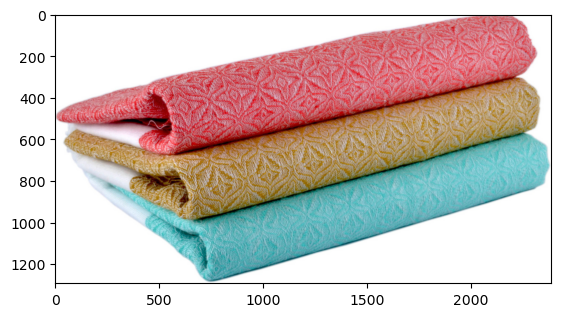

In [12]:
from matplotlib.image import imread

image = imread(img_path[1])
plt.imshow(image)

### 2.1 Prétraitement des données     

    - Test avec de plusieurs modèles avec grid search cv
    - matrice de confusion sur les prédictions du modèle de régression logistique

In [13]:
base_model = VGG16()

model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

###     Extraction des features 

In [14]:
import time

images_features = []
i=0 
t0 = time.time()
images__ = []
for image_file in img_path :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image__ = image
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model
    
duration1=time.time() - t0
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")
images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600


C:\Users\Dragomir\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000
temps de T-SNE :           393.62 secondes


(1050, 4096)

### PCA

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3)
(224, 224, 3)


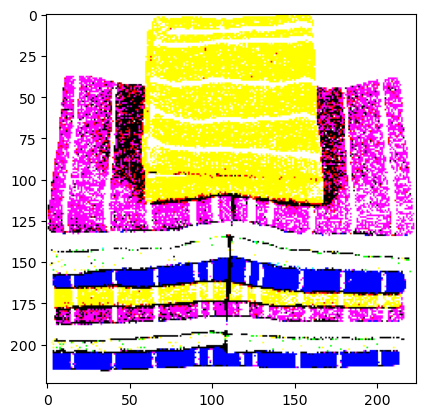

In [15]:
image = load_img(img_path[2], target_size=(224, 224))
image = img_to_array(image) 
image = np.expand_dims(image, axis=0)
print(image.shape)
image___ = preprocess_input(image)
print(image___[0].shape)
plt.imshow(image___[0])

In [16]:
images_features[0].shape

(4096,)

In [17]:
image = load_img(img_path[2], target_size=(224, 224))
image = img_to_array(image) 
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)
pred_ = base_model.predict(image, verbose=0)
decode_predictions(
    pred_,top=10
)

[[('n02808304', 'bath_towel', 0.5969709),
  ('n04599235', 'wool', 0.23637547),
  ('n04325704', 'stole', 0.02797062),
  ('n02963159', 'cardigan', 0.02310559),
  ('n03485794', 'handkerchief', 0.022774372),
  ('n03775071', 'mitten', 0.015429293),
  ('n04525038', 'velvet', 0.007649339),
  ('n03709823', 'mailbag', 0.006704906),
  ('n03188531', 'diaper', 0.006472973),
  ('n03980874', 'poncho', 0.0058937822)]]

In [18]:
base_model.inputs
base_model.layers[-2].output

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'fc2')>

In [19]:
img_path[0]

'Source/Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg'

In [56]:
test = images_features[0]

In [57]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 803)


In [58]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :             9.36 secondes


In [59]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["label"]
df_tsne['class'].unique()

array([3, 0, 5, 4, 1, 2])

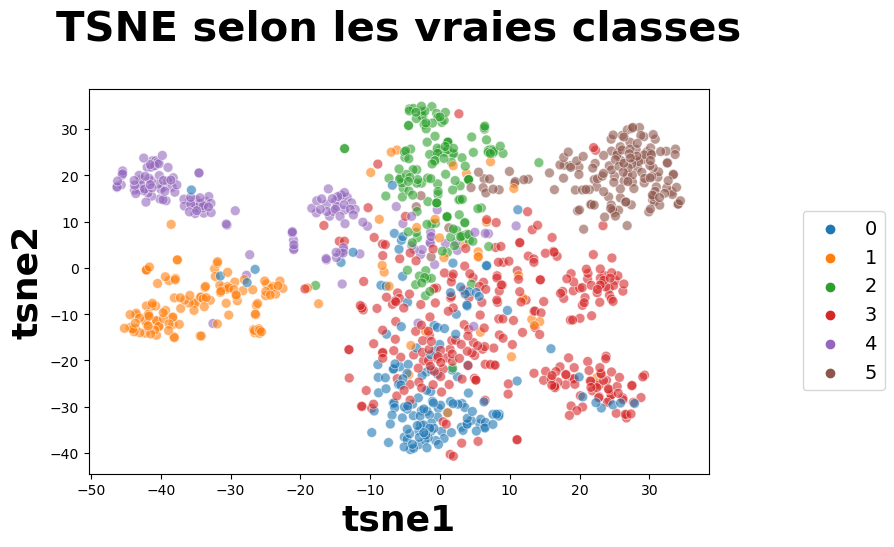

In [60]:


plt.figure(figsize=(8,5))
sns.scatterplot(
                x="tsne1",
                y="tsne2",
                hue="class",
                palette=sns.color_palette('tab10', n_colors=6), s=50, alpha=0.6,
                data=df_tsne,
                legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14},loc = 'right',bbox_to_anchor=(0.8, 0.2, 0.5, 0.5)) 

plt.show()


In [61]:
len(X_tsne[1])

2

In [62]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=6, n_init=100)
cls.fit(X_tsne)

C:\Users\Dragomir\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


KMeans(n_clusters=6, n_init=100)

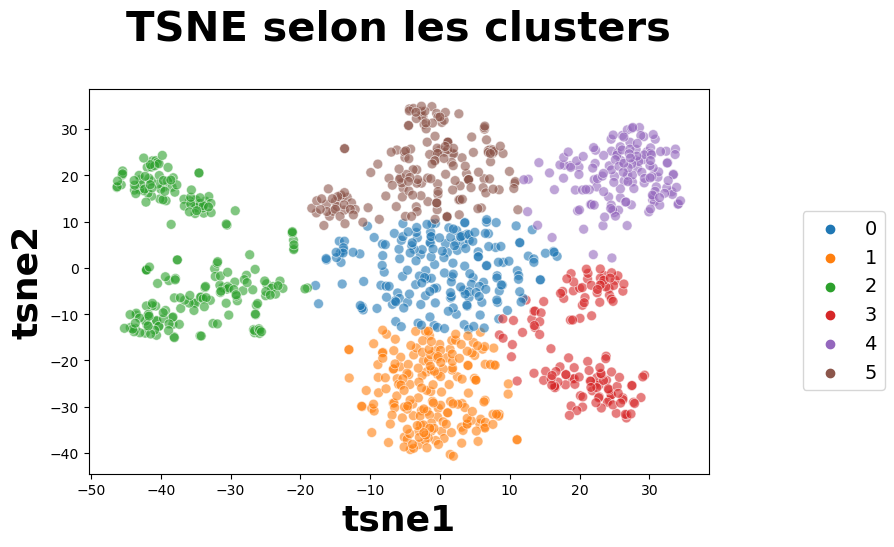

ARI :  0.3842320651180923


In [63]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=6), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14},loc = 'right',bbox_to_anchor=(0.8, 0.2, 0.5, 0.5)) 

plt.show()

labels = df["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [77]:
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV


In [80]:
pipe = Pipeline([
                ("estimator",LogisticRegression())
                ])
pipe


X = feat_pca
y = df.label


param_grid = {
              'estimator':[RandomForestClassifier(),
                           AdaBoostClassifier(),
                           GradientBoostingClassifier(),
                           ExtraTreesClassifier(),
                           DecisionTreeClassifier(),
                           SVC(),
                           BaggingClassifier(),
                           KNeighborsClassifier(13),
                           LogisticRegression()
                          ]}


grid = GridSearchCV(pipe,param_grid=param_grid, cv=10,return_train_score=True ,n_jobs=-1, verbose=1)

grid.fit(X,y)

grid_cv = pd.DataFrame(grid.cv_results_)

new_cols = [i for i in grid_cv.columns if 'split' not in i.lower()]

grid_cv.loc[:,new_cols].sort_values('mean_test_score', ascending=False)



Fitting 10 folds for each of 9 candidates, totalling 90 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
5,0.427339,0.071510,0.101101,0.014244,SVC(),{'estimator': SVC()},0.837143,0.097817,1,0.968360,0.003260
8,0.717904,0.095241,0.002999,0.002367,LogisticRegression(),{'estimator': LogisticRegression()},0.815238,0.084241,2,1.000000,0.000000
2,865.000632,5.412843,0.003500,0.001284,GradientBoostingClassifier(),{'estimator': GradientBoostingClassifier()},0.793333,0.092538,3,1.000000,0.000000
6,26.586938,1.668369,0.007302,0.000640,BaggingClassifier(),{'estimator': BaggingClassifier()},0.787619,0.083359,4,0.990370,0.003858
7,0.009702,0.003170,0.038752,0.052561,KNeighborsClassifier(n_neighbors=13),{'estimator': KNeighborsClassifier(n_neighbors...,0.786667,0.077043,5,0.837884,0.007419
0,12.524556,0.912435,0.017202,0.000601,RandomForestClassifier(),{'estimator': RandomForestClassifier()},0.734286,0.111673,6,1.000000,0.000000
4,3.483573,0.453144,0.001402,0.000490,DecisionTreeClassifier(),{'estimator': DecisionTreeClassifier()},0.709524,0.080277,7,1.000000,0.000000
3,2.601569,0.305927,0.021500,0.007283,ExtraTreesClassifier(),{'estimator': ExtraTreesClassifier()},0.667619,0.115584,8,1.000000,0.000000
1,27.554027,1.838426,0.026900,0.006090,AdaBoostClassifier(),{'estimator': AdaBoostClassifier()},0.573333,0.075208,9,0.622116,0.055777


In [81]:

from sklearn.metrics import accuracy_score, precision_recall_fscore_support as score
logistic = LogisticRegression()


X = feat_pca
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
logistic.fit(X_train, y_train)



C:\Users\Dragomir\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [89]:
y_pred = logistic.predict(X_test)
len(y_pred)

210

In [85]:
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, confusion_matrix, classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70        34
           1       0.75      0.60      0.67        25
           2       0.81      0.91      0.86        23
           3       0.78      0.80      0.79        59
           4       0.86      0.89      0.88        36
           5       0.97      0.94      0.95        33

    accuracy                           0.81       210
   macro avg       0.81      0.81      0.81       210
weighted avg       0.81      0.81      0.81       210



In [86]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

[[24  3  0  5  2  0]
 [ 1 15  3  4  2  0]
 [ 0  0 21  2  0  0]
 [ 9  1  0 47  1  1]
 [ 1  1  0  2 32  0]
 [ 0  0  2  0  0 31]]


In [87]:
list_labels = df.category_name.unique()
list_labels
nb_classe = np.arange(0,6)
nb_classe

array([0, 1, 2, 3, 4, 5])

<AxesSubplot:>

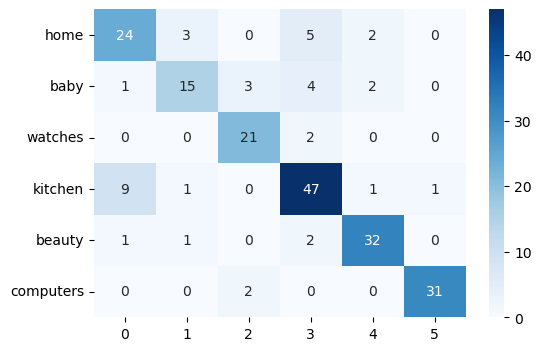

In [92]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in nb_classe])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")